# Basic experiment

# Make toy data

## Type 1. Independent Gaussian

$$
(x_1, x_2) \sim \mathcal{N}(0,I)
$$

## Type 2. Correlated Gaussian

$$
(y_1, y_2) \sim \mathcal{N}(0,\begin{bmatrix}1&\rho\\ \rho&1\end{bmatrix})
$$

In [1]:
import numpy as np

In [2]:
x = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0],[0,1]],
                                 size = 300)

In [3]:
y = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0.8],[0.8,1]],
                                 size = 300)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

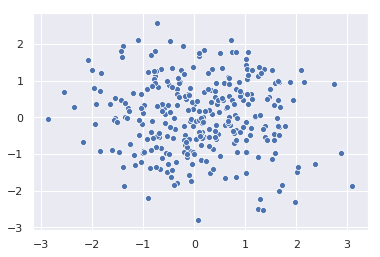

In [5]:
# plt indep Gaussian
sns.scatterplot(x=x[:,0],y=x[:,1])

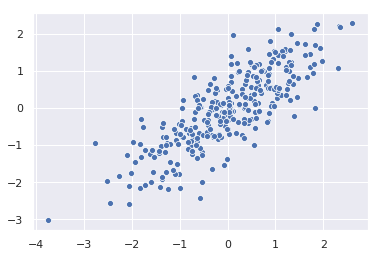

In [6]:
# plt cor Gaussian
sns.scatterplot(x=y[:,0],y=y[:,1])

# Define MINE

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

In [8]:
class Mine(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.leaky_relu(self.fc1(input))
        output = F.leaky_relu(self.fc2(output))
        output = self.fc3(output)
        return output

In [9]:
def mutual_information(joint, marginal, mine_net):
    t = mine_net(joint)
    et = torch.exp(mine_net(marginal))
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et

def learn_mine(batch, mine_net, mine_net_optim,  ma_et, ma_rate=0.01):
    # batch is a tuple of (joint, marginal)
    joint , marginal = batch
    joint = torch.autograd.Variable(torch.FloatTensor(joint)).cuda()
    marginal = torch.autograd.Variable(torch.FloatTensor(marginal)).cuda()
    mi_lb , t, et = mutual_information(joint, marginal, mine_net)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
    loss = -(torch.mean(t) - (et.mean()/ma_et.mean()).detach()*torch.log(torch.mean(et)))
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    return mi_lb, ma_et

In [10]:
def sample_batch(data, batch_size=100, sample_mode='joint'):
    if sample_mode == 'joint':
        index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = data[index]
    else:
        joint_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        marginal_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = np.concatenate([data[joint_index][:,0].reshape(-1,1),
                                         data[marginal_index][:,1].reshape(-1,1)],
                                       axis=1)
    return batch

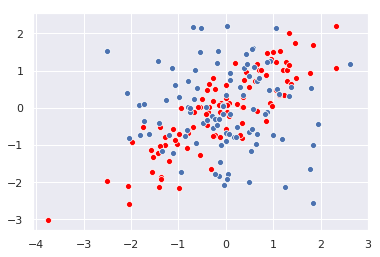

In [11]:
joint_data = sample_batch(y,batch_size=100,sample_mode='joint')
sns.scatterplot(x=joint_data[:,0],y=joint_data[:,1],color='red')
marginal_data = sample_batch(y,batch_size=100,sample_mode='marginal')
sns.scatterplot(x=marginal_data[:,0],y=marginal_data[:,1])

In [12]:
def train(data, mine_net,mine_net_optim, batch_size=100, iter_num=int(5e+3), log_freq=1e+3):
    # data is x or y
    result = list()
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_batch(data,batch_size=batch_size)\
        , sample_batch(data,batch_size=batch_size,sample_mode='marginal')
        mi_lb, ma_et = learn_mine(batch, mine_net, mine_net_optim, ma_et)
        result.append(mi_lb.detach().cpu().numpy())
        if (i+1)%(log_freq)==0:
            print(result[-1])
    return result

In [13]:
def ma(a, window_size=100):
    return [np.mean(a[i:i+window_size]) for i in range(0,len(a)-window_size)]

In [14]:
mine_net_indep = Mine().cuda()
mine_net_optim_indep = optim.Adam(mine_net_indep.parameters(), lr=1e-4)
result_indep = train(x,mine_net_indep,mine_net_optim_indep)

0.007206803
0.0146319885
0.021322235
0.0415672
0.044646658


0.044610906


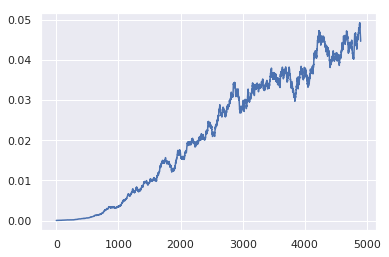

In [15]:
result_indep_ma = ma(result_indep)
print(result_indep_ma[-1])
plt.plot(range(len(result_indep_ma)),result_indep_ma)

In [16]:
mine_net_cor = Mine().cuda()
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-4)
result_cor = train(y,mine_net_cor,mine_net_optim_cor)

0.6232979
0.5405573
0.50818586
0.65317005
0.49779797


0.53176856


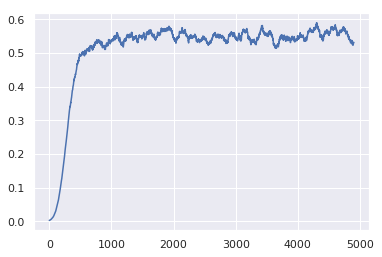

In [17]:
result_cor_ma = ma(result_cor)
print(result_cor_ma[-1])
plt.plot(range(len(result_cor_ma)),result_cor_ma)

# Test with various correlations

In [18]:
correlations = np.linspace(-0.9,0.9,19)
print(correlations)

[-0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4
  0.5  0.6  0.7  0.8  0.9]


0.82227737
0.6836201
0.5738175
0.67066544
0.7715557
-0.9 : 0.7830982
0.53418225
0.7053236
0.42087036
0.44522738
0.54696107
-0.8 : 0.52255213
0.47444025
0.41205987
0.25849217
0.17451826
0.33873588
-0.7 : 0.3506436
0.46191555
0.35786277
0.12829812
0.23216708
0.3459731
-0.6 : 0.2700637
0.18134572
0.15191096
0.20046711
0.25385624
0.10896904
-0.5 : 0.1930258
0.045189075
0.04196906
0.10128039
0.12519316
-0.014483292
-0.4 : 0.103836134
0.12498984
0.063509144
0.115972
0.06340985
0.143061
-0.29999999999999993 : 0.06038753
0.010048812
0.0066756476
0.015329331
0.02042006
0.07716946
-0.19999999999999996 : 0.04347028
0.029558469
0.049956538
-0.006471414
-0.0072422335
0.054364286
-0.09999999999999998 : 0.028937759
0.0001117902
0.00893413
0.004186107
0.0051093716
0.027102394
0.0 : 0.017623309
0.004919097
0.005465869
0.013503006
-0.0027891868
0.00381167
0.09999999999999998 : 0.018290365
0.009796597
-0.0027729236
0.124158084
-0.016607407
-0.022581466
0.20000000000000007 : 0.04339462
0.07384686
0.081480

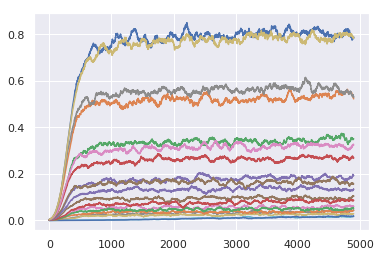

In [19]:
final_result = []
for rho in correlations:
    rho_data = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,rho],[rho,1]],
                                 size = 300)
    mine_net = Mine().cuda()
    mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-4)
    result = train(rho_data,mine_net,mine_net_optim)
    result_ma = ma(result)
    final_result.append(result_ma[-1])
    print(str(rho) + ' : ' + str(final_result[-1]))
    plt.plot(range(len(result_ma)),result_ma)

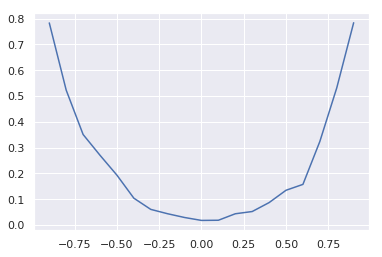

In [20]:
plt.plot(correlations, final_result)

# Equitability experiment

Check more information at [original equitability paper](http://www.pnas.org/content/pnas/111/9/3354.full.pdf).

# Make toy data

In [21]:
x = np.random.uniform(low=-1.,high=1.,size=3000)
f1 = x
f2 = 2*x
f3 = np.sin(x)
f4 = x**3
eps = np.random.normal(size=3000)

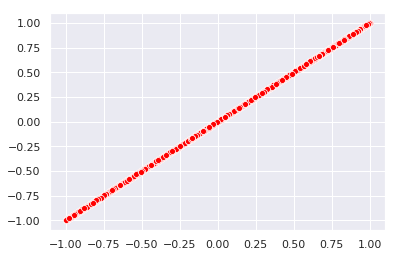

In [22]:
sns.scatterplot(x, f1,color='red')

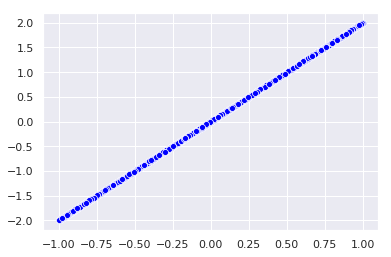

In [23]:
sns.scatterplot(x, f2,color='blue')

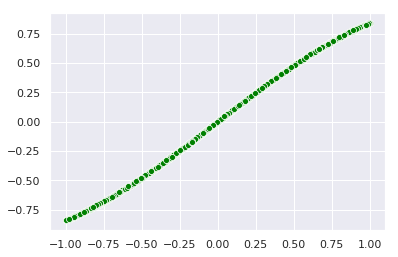

In [24]:
sns.scatterplot(x, f3,color='green')

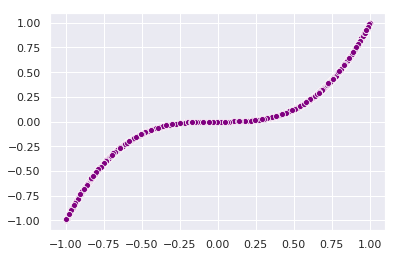

In [25]:
sns.scatterplot(x, f4,color='purple')

In [26]:
sigmas = np.linspace(0.0,0.9,10)
fs = [f1, f2, f3, f4]
print(sigmas)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


1.6985307
2.5605862
2.7364745
4.159265
3.928698
0.0,0 : 4.0275483
1.8063227
2.789754
2.9339285
5.8477464
3.108316
0.0,1 : 4.2033396
1.7933382
2.5484238
2.9599442
3.2152452
2.342321
0.0,2 : 3.0889482
0.85252744
1.1055238
1.336438
1.6109804
2.066963
0.0,3 : 1.6493802
1.5345109
1.7282392
1.5696387
1.3613901
1.3832426
0.1,0 : 1.6913196
1.6622119
2.4774344
1.9314504
1.8523659
2.2781324
0.1,1 : 2.3168507
1.3796775
1.7670941
1.6140932
1.6040154
1.8464139
0.1,2 : 1.5329278
0.6457808
0.77612066
0.8060628
1.0977063
0.70022595
0.1,3 : 0.91867393
1.0372125
0.9455553
1.0227091
0.980204
0.9070537
0.2,0 : 1.063286
1.0546838
1.5561625
1.7539446
1.7296485
1.6421835
0.2,1 : 1.6403589
0.8514122
0.81468034
0.992383
1.073936
0.79421353
0.2,2 : 0.9672243
0.54919595
0.517034
0.7767721
0.4304173
0.48904705
0.2,3 : 0.5786028
0.78134197
0.5244038
0.7916969
0.6208175
0.671486
0.30000000000000004,0 : 0.7406857
1.0234283
1.230584
1.2510493
1.380616
1.2747172
0.30000000000000004,1 : 1.2878804
0.5696533
0.7378024
0.

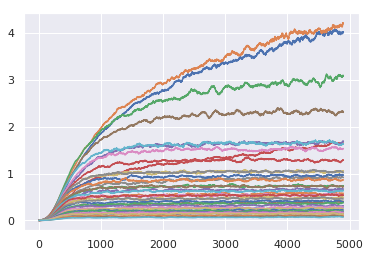

In [27]:
final_result = []
for sigma in sigmas:
    for fi, f in enumerate(fs):
        data = np.concatenate([x.reshape(-1,1), (f + sigma * eps).reshape(-1,1)], axis=1)
        mine_net = Mine().cuda()
        mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-4)
        result = train(data,mine_net,mine_net_optim,batch_size=100,iter_num=int(5e+3))
        result_ma = ma(result)
        final_result.append(result_ma[-1])
        print(str(sigma) + ',' + str(fi) +' : ' + str(final_result[-1]))
        plt.plot(range(len(result_ma)),result_ma)

In [28]:
re_final_result = np.transpose(np.array([final_result[4*i: 4*i+4]  for i in range(10)]))
print(re_final_result)

[[4.0275483  1.6913196  1.063286   0.7406857  0.54182446 0.3970416
  0.3120322  0.24829239 0.19849482 0.17046005]
 [4.2033396  2.3168507  1.6403589  1.2878804  1.0264362  0.86469406
  0.7228898  0.6371093  0.5424022  0.45881817]
 [3.0889482  1.5329278  0.9672243  0.6683219  0.49433693 0.38036457
  0.28649494 0.2225726  0.17712854 0.13985114]
 [1.6493802  0.91867393 0.5786028  0.40657115 0.2743458  0.18659832
  0.14507337 0.1114017  0.08256485 0.07156859]]


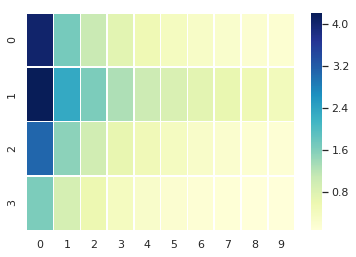

In [29]:
sns.heatmap(re_final_result,cmap="YlGnBu",linewidths=.5)